In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import learning_curve


In [42]:
def ROC(X_test,y_test):
    y_pred_proba = model.predict_proba(X_test)
    lr_probs = y_pred_proba[:,1]
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
    lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='SVM')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Treeb: ROC AUC=%.3f' % (lr_auc))

In [43]:
def curva_aprendizaje(model, X, y, score):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y,cv=10,scoring=score)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, '--', color="red", label="Training score")
    plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std,  alpha=0.15,color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std,  alpha=0.15,color="b")

    plt.title("Curva de aprendizaje")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [44]:
def curva_validacion(model, X_train,y_train, param,rango):
    train_prec, eval_prec = validation_curve(estimator = model, X = X_train, y=y_train, param_name=param,param_range=rango, cv =10)
    train_mean = np.mean(train_prec, axis = 1)
    train_std = np.mean(train_prec,axis = 1)
    test_mean = np.mean(eval_prec,axis = 1)
    test_std = np.std(eval_prec,axis=1)
    
    #Grafico
    
    plt.plot(rango,train_mean,color='r', marker = 'o',markersize = 5, label = 'Entrenamiento')
    plt.fill_between(rango, train_mean - train_std, 
                 train_mean + train_std, alpha=0.15, color='r')
    plt.plot(rango, test_mean, color='b', linestyle='--', marker='s', markersize=5, label='evaluacion')
    plt.fill_between(rango, test_mean - test_std, 
                 test_mean + test_std, alpha=0.15, color='b')
    plt.grid()
    plt.legend(loc='center right')
    plt.xlabel('Cant de nodos')
    plt.ylabel('Precision')
    plt.show()

In [45]:
data = pd.read_csv('./dataA.csv')
data.head(1)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine
0,-0.084787,-0.68541,-0.244709,-0.196223,0.361252,-0.132463,-0.625504,-0.317443,-0.359303,-0.336093,...,-0.343648,-0.398552,-0.417145,-0.476095,-0.558694,0,0,1,0,0


# Best Features

In [46]:
best_feature_pure = ['p2_d', 'p3_d', 'min_d', 'first_sp', 'second_sp', 'first_dp',
       'second_dp', 'First_Protocol_TCP']

In [47]:
y = data['Type_mine']
X = data[best_feature_pure]

# Holdout

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3)

In [49]:
model = svm.SVC(probability=True)

In [50]:
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [51]:
y_pred = model.predict(X_test)

In [52]:
print("El modelo de SVM se equivocó en %d de los %d registros que componen el dataset original"
      % ((y_test != y_pred).sum(), data.shape[0]))

El modelo de SVM se equivocó en 3 de los 4733 registros que componen el dataset original


([<matplotlib.axis.YTick at 0x291cd0765c0>,
 <a list of 2 Text yticklabel objects>)

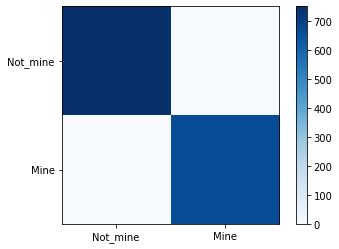

In [53]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [54]:
pd.DataFrame(churm)

,0,1
0,751,3
1,0,666


In [55]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa: ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.997887323943662
Kappa:  0.9957594725022696


In [56]:
print(colored('Metricas de los registros mineros', attrs=['bold']))

print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[1], average='macro'))

VN = churm[0,0]
FP = churm[0,1]
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[1], average='macro'))

Metricas de los registros mineros
Precisión     :  0.9955156950672646
Recall        :  1.0
Especificidad :  0.9960212201591512
F1-score      :  0.9977528089887641


In [57]:
print(colored('Metricas de los registros no mineros', attrs=['bold']))

print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[0], average='macro'))

VN = churm[1,1]
FP = churm[1,0]
specificity = VN/(VN+FP)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[0], average='macro'))

Metricas de los registros no mineros
Precisión     :  1.0
Recall        :  0.9960212201591512
Especificidad :  1.0
F1-score      :  0.9980066445182724


In [58]:
mse, bias, var =  bias_variance_decomp(model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='mse', num_rounds=200)
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.002
Bias: 0.002
Variance: 0.000


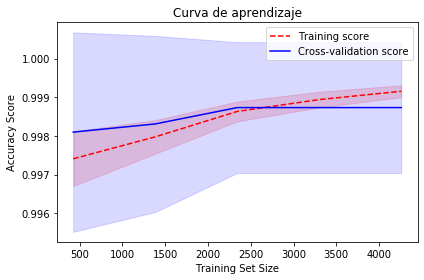

In [59]:
curva_aprendizaje(model, X, y, 'accuracy')

In [60]:
s

NameError: name 's' is not defined

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(svm.SVC(probability=True), 
                                                        X, y,cv=10,scoring='accuracy')

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="red",  label="Training score")
plt.plot(train_sizes, test_mean, color="blue", label="Cross-validation score")

#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="gray")
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="gray")

plt.title("Curva de aprendizaje")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

# ROC

In [ ]:
ROC(X_test,y_test,model)